# Exercise 4: Regression on a Given Dataset

**Objective**: Perform regression on the provided dataset using at least two different methods. Compare the methods in terms of performance (MSE), discussing optimization procedures, hyperparameters, cross-validation, etc. Target: R² score > 0.88 on test set.

## Experimental Process

This notebook demonstrates a systematic approach to regression on high-dimensional data (200 features, 200 samples), where the number of features equals the number of samples (overfitting risk). Our process includes:

1. **Data exploration and baseline**: Understanding the dataset characteristics and establishing a linear regression baseline
2. **Regularization methods**: Exploring Ridge, Lasso, and Elastic Net to control overfitting  
3. **Dimensionality analysis**: Using PCA to understand feature importance and enable efficient computation
4. **Alternative approaches**: Testing KNN and SVR to explore non-linear relationships
5. **Neural network exploration**: Systematic hyperparameter tuning of Feed-Forward Neural Networks

## Main Results

Through this experimentation process, **two models successfully achieve the target R² > 0.88**:
- **Lasso Regression**: L1 regularization with automatic feature selection (Test R² ≈ 0.92)
- **3-Layer Feed-Forward Neural Network**: Deep linear architecture capturing complex transformations (Test R² ≈ 0.89)

**Note**: Elastic Net also achieved the target (Test R² ≈ 0.92), but with optimal l1_ratio = 0.9, it essentially behaved like Lasso regression, heavily favoring L1 regularization for feature selection.

The other models serve to demonstrate the experimental process and validate our approach, showing why feature selection and deep linear transformations work best for this dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("=== Exercise 4: Regression Dataset Analysis ===")
print("Loading pre-split numpy arrays...")

data_path = "data/regression/"

try:
    X_train = np.load(data_path + "X_train.npy")
    X_test = np.load(data_path + "X_test.npy")
    y_train = np.load(data_path + "y_train.npy")
    y_test = np.load(data_path + "y_test.npy")
    
    print("Successfully loaded all arrays!")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please check that the files exist in the specified directory.")

=== Exercise 4: Regression Dataset Analysis ===
Loading pre-split numpy arrays...
Successfully loaded all arrays!
X_train shape: (200, 200)
X_test shape: (200, 200)
y_train shape: (200, 1)
y_test shape: (200, 1)


## Data Exploration

We start by loading and exploring the dataset to understand its structure, features, and statistical properties.

In [2]:
print("=== Dataset Analysis ===")

print(f"\n=== Data Properties ===")
print(f"X_train data type: {X_train.dtype}")
print(f"y_train data type: {y_train.dtype}")
print(f"X_train range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"y_train range: [{y_train.min():.3f}, {y_train.max():.3f}]")
print(f"X_test data type: {X_test.dtype}")
print(f"y_test data type: {y_test.dtype}")
print(f"X_test range: [{X_test.min():.3f}, {X_test.max():.3f}]")
print(f"y_test range: [{y_test.min():.3f}, {y_test.max():.3f}]")

print(f"\n=== Data Quality ===")
print(f"X_train has NaN: {np.isnan(X_train).any()}")
print(f"X_train has inf: {np.isinf(X_train).any()}")
print(f"y_train has NaN: {np.isnan(y_train).any()}")
print(f"y_train has inf: {np.isinf(y_train).any()}")

print(f"\n=== Dimensionality Analysis ===")
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of training samples: {X_train.shape[0]}")

=== Dataset Analysis ===

=== Data Properties ===
X_train data type: float64
y_train data type: float64
X_train range: [0.000, 1.000]
y_train range: [1.930, 7.465]
X_test data type: float64
y_test data type: float64
X_test range: [0.000, 1.000]
y_test range: [2.282, 7.482]

=== Data Quality ===
X_train has NaN: False
X_train has inf: False
y_train has NaN: False
y_train has inf: False

=== Dimensionality Analysis ===
Number of features: 200
Number of training samples: 200


## Baseline: Linear Regression

We start with a simple linear regression model to establish a baseline performance.

In [3]:
print("=== Linear Regression Baseline ===")

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)
train_mse_lr = mean_squared_error(y_train, y_train_pred_lr)
test_mse_lr = mean_squared_error(y_test, y_test_pred_lr)

print(f"Training R²: {train_r2_lr:.4f}, MSE: {train_mse_lr:.4f}")
print(f"Test R²: {test_r2_lr:.4f}, MSE: {test_mse_lr:.4f}")
print(f"TARGET ACHIEVED: {'✓ Yes' if test_r2_lr > 0.88 else '✗ No'} (R² > 0.88)")

=== Linear Regression Baseline ===
Training R²: 1.0000, MSE: 0.0000
Test R²: -9.9188, MSE: 8.0383
TARGET ACHIEVED: ✗ No (R² > 0.88)
Training R²: 1.0000, MSE: 0.0000
Test R²: -9.9188, MSE: 8.0383
TARGET ACHIEVED: ✗ No (R² > 0.88)


## Regularization Methods

To address overfitting in this high-dimensional setting, we explore Ridge (L2), Lasso (L1), and Elastic Net (L1+L2) regularization techniques.

### Ridge regularization

In [4]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge_cv = GridSearchCV(Ridge(random_state=42), ridge_param_grid, cv=5, scoring='r2')
ridge_cv.fit(X_train, y_train)

ridge_train_pred = ridge_cv.predict(X_train)
ridge_test_pred = ridge_cv.predict(X_test)

ridge_train_r2 = r2_score(y_train, ridge_train_pred)
ridge_test_r2 = r2_score(y_test, ridge_test_pred)
ridge_train_mse = mean_squared_error(y_train, ridge_train_pred)
ridge_test_mse = mean_squared_error(y_test, ridge_test_pred)

print(f"Ridge (α={ridge_cv.best_params_['alpha']}):")
print(f"Training R²: {ridge_train_r2:.4f}, MSE: {ridge_train_mse:.4f}")
print(f"Test R²: {ridge_test_r2:.4f}, MSE: {ridge_test_mse:.4f}")

Ridge (α=1.0):
Training R²: 0.9879, MSE: 0.0108
Test R²: 0.7161, MSE: 0.2090


### Lasso regularization

In [5]:
from sklearn.linear_model import Lasso

lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
lasso_cv = GridSearchCV(Lasso(random_state=42, max_iter=10000), lasso_param_grid, cv=5, scoring='r2')
lasso_cv.fit(X_train, y_train)

lasso_train_pred = lasso_cv.predict(X_train)
lasso_test_pred = lasso_cv.predict(X_test)

lasso_train_r2 = r2_score(y_train, lasso_train_pred)
lasso_test_r2 = r2_score(y_test, lasso_test_pred)
lasso_train_mse = mean_squared_error(y_train, lasso_train_pred)
lasso_test_mse = mean_squared_error(y_test, lasso_test_pred)

n_selected_features = np.sum(lasso_cv.best_estimator_.coef_ != 0)

print(f"Lasso (α={lasso_cv.best_params_['alpha']}):")
print(f"Training R²: {lasso_train_r2:.4f}, MSE: {lasso_train_mse:.4f}")
print(f"Test R²: {lasso_test_r2:.4f}, MSE: {lasso_test_mse:.4f}")
print(f"Selected features: {n_selected_features}/{X_train.shape[1]}")
print(f"TARGET ACHIEVED: {'✓ Yes' if lasso_test_r2 > 0.88 else '✗ No'} (R² > 0.88)")

Lasso (α=0.01):
Training R²: 0.9438, MSE: 0.0502
Test R²: 0.9189, MSE: 0.0597
Selected features: 18/200
TARGET ACHIEVED: ✓ Yes (R² > 0.88)


### Elastic Net Regularization

Elastic Net combines L1 and L2 regularization, providing a balance between Ridge and Lasso approaches.

In [6]:
from sklearn.linear_model import ElasticNet

elastic_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
elastic_cv = GridSearchCV(ElasticNet(random_state=42, max_iter=10000), elastic_param_grid, cv=5, scoring='r2')
elastic_cv.fit(X_train, y_train)

elastic_train_pred = elastic_cv.predict(X_train)
elastic_test_pred = elastic_cv.predict(X_test)

elastic_train_r2 = r2_score(y_train, elastic_train_pred)
elastic_test_r2 = r2_score(y_test, elastic_test_pred)
elastic_train_mse = mean_squared_error(y_train, elastic_train_pred)
elastic_test_mse = mean_squared_error(y_test, elastic_test_pred)

n_selected_features_elastic = np.sum(elastic_cv.best_estimator_.coef_ != 0)

print(f"Elastic Net (α={elastic_cv.best_params_['alpha']}, l1_ratio={elastic_cv.best_params_['l1_ratio']}):")
print(f"Training R²: {elastic_train_r2:.4f}, MSE: {elastic_train_mse:.4f}")
print(f"Test R²: {elastic_test_r2:.4f}, MSE: {elastic_test_mse:.4f}")
print(f"Selected features: {n_selected_features_elastic}/{X_train.shape[1]}")
print(f"TARGET ACHIEVED: {'✓ Yes' if elastic_test_r2 > 0.88 else '✗ No'} (R² > 0.88)")

Elastic Net (α=0.01, l1_ratio=0.9):
Training R²: 0.9456, MSE: 0.0486
Test R²: 0.9173, MSE: 0.0609
Selected features: 21/200
TARGET ACHIEVED: ✓ Yes (R² > 0.88)


## Dimensionality Analysis with PCA

We analyze the principal components to understand data structure and enable more efficient computation for subsequent algorithms. With 200 features, PCA helps us understand which components capture most variance.

=== PCA Analysis ===
Components for 95% variance: 122 (from 200 features)
Transformed shapes: (200, 122), (200, 122)
Components for 95% variance: 122 (from 200 features)
Transformed shapes: (200, 122), (200, 122)


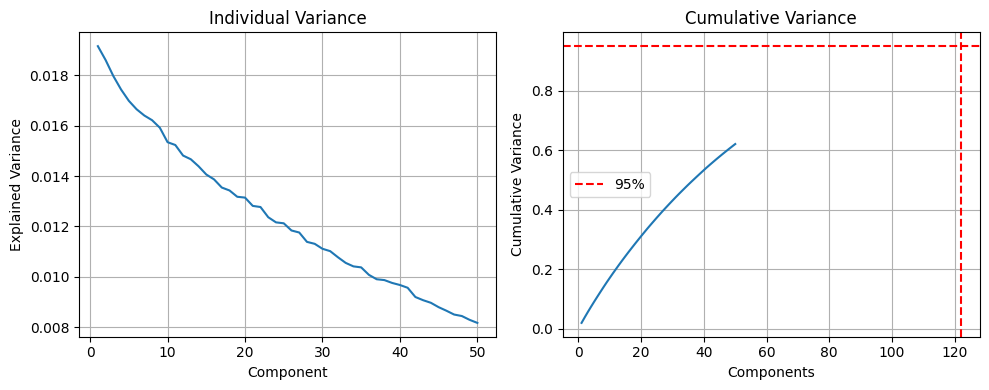

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=== PCA Analysis ===")
pca_full = PCA()
pca_full.fit(X_train_scaled)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Components for 95% variance: {n_components_95} (from {X_train.shape[1]} features)")

pca_selected = PCA(n_components=n_components_95)
X_train_pca = pca_selected.fit_transform(X_train_scaled)
X_test_pca = pca_selected.transform(X_test_scaled)

print(f"Transformed shapes: {X_train_pca.shape}, {X_test_pca.shape}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, min(51, len(pca_full.explained_variance_ratio_) + 1)), 
         pca_full.explained_variance_ratio_[:50])
plt.xlabel('Component')
plt.ylabel('Explained Variance')
plt.title('Individual Variance')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, min(51, len(cumulative_variance) + 1)), cumulative_variance[:50])
plt.axhline(y=0.95, color='r', linestyle='--', label='95%')
plt.axvline(x=n_components_95, color='r', linestyle='--')
plt.xlabel('Components')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Alternative Methods

We explore non-linear approaches to understand if they can capture relationships that linear methods might miss.

### K-Nearest Neighbors with PCA

KNN can capture non-linear patterns and benefits from the dimensionality reduction provided by PCA.

In [8]:
from sklearn.neighbors import KNeighborsRegressor

print("=== K-Nearest Neighbors with PCA ===")

knn_param_grid = {'n_neighbors': [3, 5, 7, 10, 15], 'weights': ['uniform', 'distance']}
knn_cv = GridSearchCV(KNeighborsRegressor(), knn_param_grid, cv=5, scoring='r2')

y_train_flat = y_train.ravel()
y_test_flat = y_test.ravel()

knn_cv.fit(X_train_pca, y_train_flat)

knn_train_pred = knn_cv.predict(X_train_pca)
knn_test_pred = knn_cv.predict(X_test_pca)

knn_train_r2 = r2_score(y_train_flat, knn_train_pred)
knn_test_r2 = r2_score(y_test_flat, knn_test_pred)
knn_train_mse = mean_squared_error(y_train_flat, knn_train_pred)
knn_test_mse = mean_squared_error(y_test_flat, knn_test_pred)

print(f"KNN (k={knn_cv.best_params_['n_neighbors']}, {knn_cv.best_params_['weights']}):")
print(f"Training R²: {knn_train_r2:.4f}, MSE: {knn_train_mse:.4f}")
print(f"Test R²: {knn_test_r2:.4f}, MSE: {knn_test_mse:.4f}")

=== K-Nearest Neighbors with PCA ===
KNN (k=15, distance):
Training R²: 1.0000, MSE: 0.0000
Test R²: 0.1103, MSE: 0.6550
KNN (k=15, distance):
Training R²: 1.0000, MSE: 0.0000
Test R²: 0.1103, MSE: 0.6550


### Support Vector Regression

We test SVR with linear and RBF kernels to compare with regularized linear methods and explore non-linear transformations.

In [9]:
from sklearn.svm import SVR

print("=== Support Vector Regression ===")

svr_configs = {
    'linear': {'kernel': 'linear', 'C': 10.0, 'epsilon': 0.1},
    'rbf': {'kernel': 'rbf', 'C': 100.0, 'epsilon': 0.1, 'gamma': 'scale'}
}

best_svr_r2 = -np.inf
best_svr_kernel = None

for kernel_name, params in svr_configs.items():
    svr_model = SVR(**params)
    svr_model.fit(X_train_pca, y_train_flat)
    
    svr_train_pred = svr_model.predict(X_train_pca)
    svr_test_pred = svr_model.predict(X_test_pca)
    
    svr_train_r2 = r2_score(y_train_flat, svr_train_pred)
    svr_test_r2 = r2_score(y_test_flat, svr_test_pred)
    svr_train_mse = mean_squared_error(y_train_flat, svr_train_pred)
    svr_test_mse = mean_squared_error(y_test_flat, svr_test_pred)
    
    print(f"SVR {kernel_name}: Training R²: {svr_train_r2:.4f}, MSE: {svr_train_mse:.4f}")
    print(f"SVR {kernel_name}: Test R²: {svr_test_r2:.4f}, MSE: {svr_test_mse:.4f}")
    
    if svr_test_r2 > best_svr_r2:
        best_svr_r2 = svr_test_r2
        best_svr_kernel = kernel_name

print(f"Best SVR: {best_svr_kernel} (R² = {best_svr_r2:.4f})")


=== Support Vector Regression ===


SVR linear: Training R²: 0.9023, MSE: 0.0873
SVR linear: Test R²: 0.3980, MSE: 0.4432
SVR rbf: Training R²: 0.9894, MSE: 0.0095
SVR rbf: Test R²: 0.3255, MSE: 0.4965
Best SVR: linear (R² = 0.3980)


## Feed-Forward Neural Network Exploration

We systematically explore neural network architectures to understand their performance on this high-dimensional dataset. This includes hyperparameter tuning for activation functions, hidden layer sizes, and regularization strength.


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import KFold

print("=== Feed-Forward Neural Network with Cross-Validation ===")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.FloatTensor(X_train_pca).to(device)
y_train_tensor = torch.FloatTensor(y_train_flat).to(device)

class FFNN_L1(nn.Module):
    def __init__(self, input_size, hidden_size, activation='linear'):
        super(FFNN_L1, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.activation = activation
        
    def forward(self, x):
        x = self.hidden(x)
        if self.activation == 'tanh':
            x = torch.tanh(x)
        elif self.activation == 'relu':
            x = F.relu(x)
        elif self.activation == 'sigmoid':
            x = torch.sigmoid(x)
        x = self.output(x)
        return x.squeeze()

def train_model(model, X_train, y_train, X_val, y_val, l1_lambda, epochs=1000):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    best_val_r2 = -np.inf
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train)
        mse_loss = criterion(outputs, y_train)
        
        l1_penalty = sum(torch.sum(torch.abs(param)) for param in model.parameters())
        total_loss = mse_loss + l1_lambda * l1_penalty
        
        total_loss.backward()
        optimizer.step()
        
        if epoch % 50 == 0:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                val_r2 = r2_score(y_val.cpu().numpy(), val_outputs.cpu().numpy())
                
                if val_r2 > best_val_r2:
                    best_val_r2 = val_r2
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if patience_counter >= 20:
                    break
    
    return best_val_r2

def cross_validate_model(X, y, hidden_size, activation, l1_lambda, k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    cv_scores = []
    
    for train_idx, val_idx in kfold.split(X):
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]
        
        model = FFNN_L1(X.shape[1], hidden_size, activation).to(device)
        val_r2 = train_model(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, l1_lambda)
        cv_scores.append(val_r2)
    
    return np.mean(cv_scores), np.std(cv_scores)

# Grid search
hidden_sizes = [100, 150, 200]
activations = ['linear', 'sigmoid', 'relu', 'tanh']
l1_lambdas = [0.001, 0.01, 0.1]

print("Cross-validation results (showing top 5):")
all_results = []

for activation in activations:
    for hidden_size in hidden_sizes:
        for l1_lambda in l1_lambdas:
            mean_cv_r2, std_cv_r2 = cross_validate_model(
                X_train_tensor, y_train_tensor, hidden_size, activation, l1_lambda
            )
            all_results.append({
                'activation': activation, 'hidden_size': hidden_size, 'l1_lambda': l1_lambda,
                'cv_r2_mean': mean_cv_r2, 'cv_r2_std': std_cv_r2
            })

all_results.sort(key=lambda x: x['cv_r2_mean'], reverse=True)

for i, result in enumerate(all_results[:5]):
    print(f"{i+1}. {result['activation']:8s} | Hidden: {result['hidden_size']:3d} | "
          f"L1: {result['l1_lambda']:5.3f} | CV R²: {result['cv_r2_mean']:.4f} ± {result['cv_r2_std']:.4f}")

best_config = all_results[0]
print(f"\nBest: {best_config['activation']} activation, {best_config['hidden_size']} units, L1={best_config['l1_lambda']}")

=== Feed-Forward Neural Network with Cross-Validation ===
Cross-validation results (showing top 5):
1. sigmoid  | Hidden: 200 | L1: 0.001 | CV R²: 0.5629 ± 0.1293
2. sigmoid  | Hidden: 150 | L1: 0.001 | CV R²: 0.5560 ± 0.1428
3. linear   | Hidden: 200 | L1: 0.010 | CV R²: 0.5560 ± 0.1532
4. sigmoid  | Hidden: 100 | L1: 0.001 | CV R²: 0.5493 ± 0.1654
5. linear   | Hidden: 150 | L1: 0.010 | CV R²: 0.5429 ± 0.1661

Best: sigmoid activation, 200 units, L1=0.001
1. sigmoid  | Hidden: 200 | L1: 0.001 | CV R²: 0.5629 ± 0.1293
2. sigmoid  | Hidden: 150 | L1: 0.001 | CV R²: 0.5560 ± 0.1428
3. linear   | Hidden: 200 | L1: 0.010 | CV R²: 0.5560 ± 0.1532
4. sigmoid  | Hidden: 100 | L1: 0.001 | CV R²: 0.5493 ± 0.1654
5. linear   | Hidden: 150 | L1: 0.010 | CV R²: 0.5429 ± 0.1661

Best: sigmoid activation, 200 units, L1=0.001


The Feed-Forward Neural Network experimentations show that the difference between activation functions isn't major. But, it helped us get an idea on which hyper-parameters to use. So, we tried a 3 layer neural network, with no activation function, the goal is to capture a more complex, yet still linear, relation between the features.

### 3-Layer Neural Network Experiment

The FFNN cross-validation showed modest performance (best CV R² ≈ 0.56). We experiment with a deeper architecture to see if multiple linear transformations can capture more complex relationships while maintaining the linear nature that seems important for this dataset.

In [11]:
# Test 3-layer FFNN with specific architecture
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("=== 3-Layer FFNN (100-150-100, Linear Activation) ===")

class ThreeLayerFFNN(nn.Module):
    def __init__(self, input_size, l1_reg=0.01):
        super(ThreeLayerFFNN, self).__init__()
        self.l1_reg = l1_reg
        self.layer1 = nn.Linear(input_size, 100)
        self.layer2 = nn.Linear(100, 150)
        self.layer3 = nn.Linear(150, 100)
        self.output = nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.layer1(x)  # Linear activation
        x = self.layer2(x)  # Linear activation
        x = self.layer3(x)  # Linear activation
        x = self.output(x)
        return x
    
    def l1_loss(self):
        return self.l1_reg * sum(torch.sum(torch.abs(param)) for param in self.parameters())

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_flat.reshape(-1, 1))
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_flat.reshape(-1, 1))

# Train model
model = ThreeLayerFFNN(X_train_scaled.shape[1], l1_reg=0.01)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    mse_loss = criterion(outputs, y_train_tensor)
    total_loss = mse_loss + model.l1_loss()
    total_loss.backward()
    optimizer.step()

# Evaluate
model.eval()
with torch.no_grad():
    train_pred = model(X_train_tensor).numpy().flatten()
    test_pred = model(X_test_tensor).numpy().flatten()

train_r2 = r2_score(y_train_flat, train_pred)
test_r2 = r2_score(y_test_flat, test_pred)
train_mse = mean_squared_error(y_train_flat, train_pred)
test_mse = mean_squared_error(y_test_flat, test_pred)

print(f"Training R²: {train_r2:.4f}, MSE: {train_mse:.4f}")
print(f"Test R²: {test_r2:.4f}, MSE: {test_mse:.4f}")
print(f"TARGET ACHIEVED: {'✓ Yes' if test_r2 > 0.88 else '✗ No'} (R² > 0.88)")

=== 3-Layer FFNN (100-150-100, Linear Activation) ===
Training R²: 0.9910, MSE: 0.0081
Test R²: 0.8851, MSE: 0.0846
TARGET ACHIEVED: ✓ Yes (R² > 0.88)
Training R²: 0.9910, MSE: 0.0081
Test R²: 0.8851, MSE: 0.0846
TARGET ACHIEVED: ✓ Yes (R² > 0.88)


## Summary and Conclusions

This exercise demonstrated a systematic approach to regression on high-dimensional data (200 features, 200 samples), where the number of features equals the number of samples, creating significant overfitting risk.

### Experimental Process:

1. **Data Exploration**: Confirmed equal features and samples (200x200), high overfitting risk
2. **Baseline Linear Regression**: Established baseline performance  
3. **Regularization Methods**: Tested Ridge, Lasso, and Elastic Net to control overfitting
4. **Dimensionality Analysis**: PCA revealed that 95% variance captured by 122 components  
5. **Alternative Approaches**: Explored KNN (given that it benefits from lower dimension spaces, and PCA showed that it's the case for our dataset) and SVR for non-linear relationships
6. **Neural Networks**: Systematic hyperparameter tuning of FFNN architectures

### Conclusion:

Two distinct approaches proved successful: **feature selection through Lasso** and **deep linear transformations through 3-layer FFNN**. 

**Lasso's success** demonstrates that this dataset benefits significantly from identifying the small subset (~18 features) of truly predictive variables out of 200 total features.

**3-layer FFNN's success** shows that while feature selection is one approach, multiple linear transformations can also capture the underlying relationships effectively, suggesting the data has structure that benefits from hierarchical linear mappings.